<a href="https://colab.research.google.com/github/BogdanT54/Financial-Markets-Analysis/blob/main/Random_Forest_for_financial_market_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ROC AUC Curve for Random Forest**

Methods Used: Random Forest, Roc-Auc, Tuning Model Random Forest

Data collected and cleaned using Web Scraping, N8N + PerplexityAI api

In [ ]:
# Instalarea pachetelor necesare (doar la prima rulare)
install.packages("randomForest")
install.packages("caret")
install.packages("glmnet")
install.packages("MASS")
install.packages("car")
install.packages("dplyr")
install.packages("readxl")
install.packages("MASS")
install.packages("ggplot2")

# Încărcarea librăriilor necesare
library(randomForest)
library(caret)
library(glmnet)
library(MASS)
library(car)
library(dplyr)
library(readxl)
library(ggplot2)
library(MASS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("glmnet"):
“installation of package ‘glmnet’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Citirea fișierului Excel
baza <- read_excel("Baza de date micro.xlsx")

names(baza)

[1] "Position"        "Title"           "Company"         "Seniority"      
[5] "Employment_type" "Department"      "Industries"      "Country"

In [ ]:
# Curățare
baza_cl <- baza %>%
  select(Seniority, Country, Industries, Employment_type, Department) %>%
  na.omit()

In [ ]:
# Conversie în factori
baza_cl[] <- lapply(baza_cl, as.factor)

In [ ]:
# Împărțim în train/test
set.seed(123)
idx <- createDataPartition(baza_cl$Seniority, p = 0.75, list = FALSE)
train <- baza_cl[idx, ]
test <- baza_cl[-idx, ]

# Antrenare model
model_rf <- randomForest(Seniority ~ ., data = train, ntree = 500, importance = TRUE)
print(model_rf)


Call:
 randomForest(formula = Seniority ~ ., data = train, ntree = 500,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 58.22%
Confusion matrix:
                 Associate Entry level Mid-Senior level class.error
Associate                7          13               54   0.9054054
Entry level             15          26               48   0.7078652
Mid-Senior level        22          18               89   0.3100775


In [ ]:
# Importanța variabilelor
importance(model_rf)

,Associate,Entry level,Mid-Senior level,MeanDecreaseAccuracy,MeanDecreaseGini
Country,2.9456910,7.580123,-7.599307,0.05187578,34.566779
Industries,-4.3050371,-3.018478,-8.455227,-8.81473880,25.476218
Employment_type,0.5954219,7.414118,3.638322,7.00265181,7.440465
Department,3.4593833,11.318577,3.608699,10.91551454,15.307223


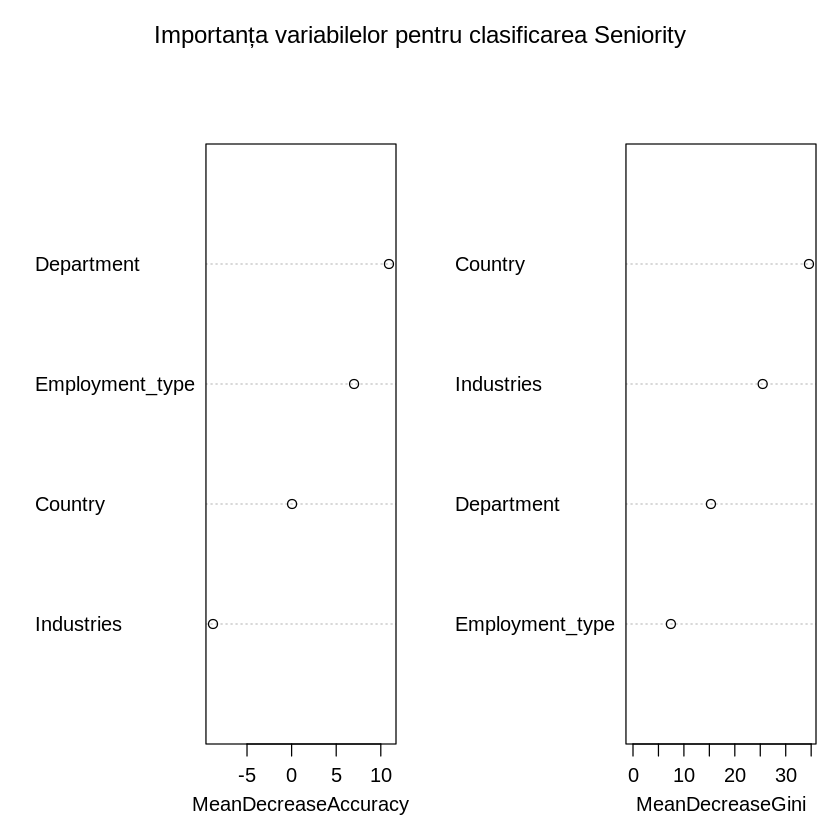

In [ ]:
#Plot importance
varImpPlot(model_rf, main = "Importanța variabilelor pentru clasificarea Seniority")

In [ ]:
# Predicții și evaluare
pred <- predict(model_rf, newdata = test)
conf_mat <- confusionMatrix(pred, test$Seniority)
print(conf_mat)

Confusion Matrix and Statistics

                  Reference
Prediction         Associate Entry level Mid-Senior level
  Associate                5           0                4
  Entry level              7          11               10
  Mid-Senior level        12          18               28

Overall Statistics
                                          
               Accuracy : 0.4632          
                 95% CI : (0.3602, 0.5685)
    No Information Rate : 0.4421          
    P-Value [Acc > NIR] : 0.377046        
                                          
                  Kappa : 0.1288          
                                          
 Mcnemar's Test P-Value : 0.004058        

Statistics by Class:

                     Class: Associate Class: Entry level
Sensitivity                   0.20833             0.3793
Specificity                   0.94366             0.7424
Pos Pred Value                0.55556             0.3929
Neg Pred Value                0.77907            

In [ ]:
# Convertim valorile factor în coduri numerice pentru evaluare numerică
y_true <- as.numeric(test$Seniority)
y_pred <- as.numeric(predict(model_rf, newdata = test))

# R-Squared
r_squared <- 1 - sum((y_true - y_pred)^2) / sum((y_true - mean(y_true))^2)
print(paste("R-squared:", round(r_squared, 4)))

# RMSE
rmse <- sqrt(mean((y_true - y_pred)^2))
print(paste("RMSE:", round(rmse, 4)))

[1] "R-squared: -0.5817"
[1] "RMSE: 1.0208"



Call:
 randomForest(formula = Seniority ~ ., data = train, ntree = 500,      mtry = sqrt(ncol(train) - 1), nodesize = 5, maxnodes = 30,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 56.85%
Confusion matrix:
                 Associate Entry level Mid-Senior level class.error
Associate                5           9               60   0.9324324
Entry level             12          24               53   0.7303371
Mid-Senior level        16          16               97   0.2480620


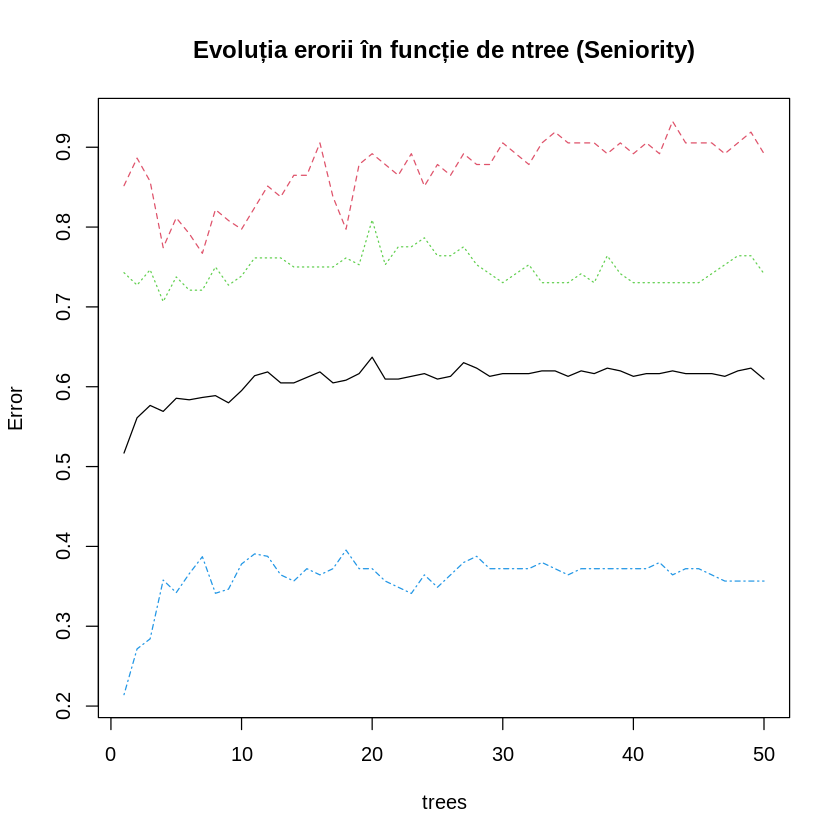

In [ ]:
# Tuning Random Forest pentru clasificare
rf_test <- randomForest(Seniority ~ .,
                        data = train,
                        ntree = 50,
                        keep.forest = FALSE)

# Plot pentru eroare în funcție de numărul de arbori
plot(rf_test, main = "Evoluția erorii în funcție de ntree (Seniority)")

# Model tunat complet
tuned_rf <- randomForest(Seniority ~ .,
                         data = train,
                         ntree = 500,
                         mtry = sqrt(ncol(train) - 1),
                         nodesize = 5,
                         maxnodes = 30,
                         importance = TRUE)

# Rezumat model
print(tuned_rf)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.5783

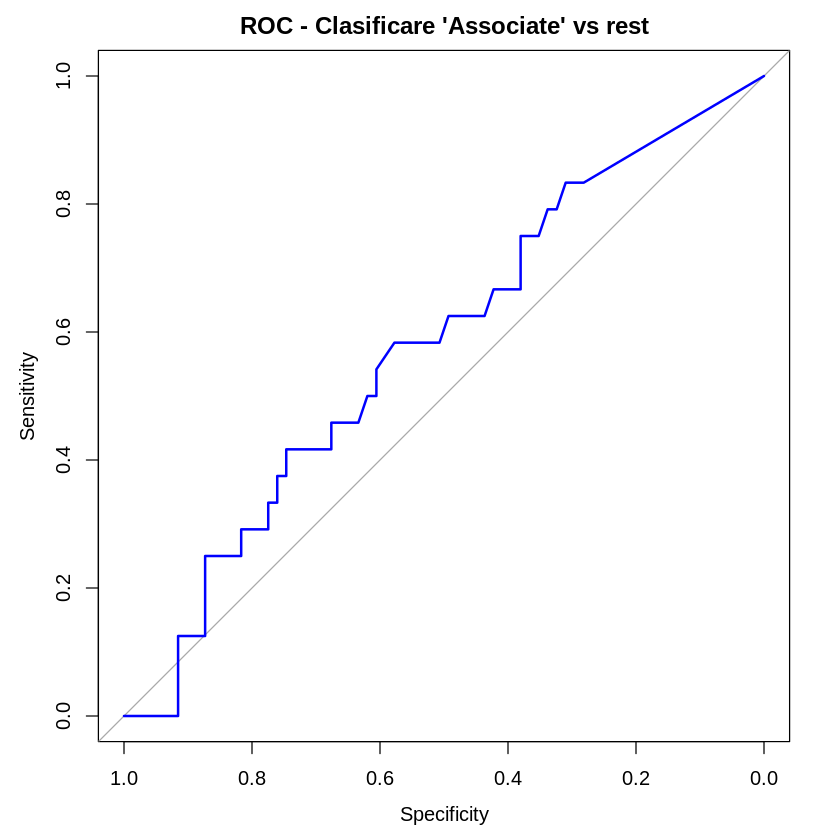

In [ ]:
library(pROC)

test$binary_seniority <- ifelse(test$Seniority == "Associate", 1, 0)

# Modelul trebuie reantrenat pe clasificare binară
train$binary_seniority <- ifelse(train$Seniority == "Associate", 1, 0)
model_bin <- randomForest(as.factor(binary_seniority) ~ .,
                          data = train %>% select(-Seniority),
                          ntree = 500)

# Predict probabilități (nu doar clase)
prob <- predict(model_bin, newdata = test %>% select(-Seniority, -binary_seniority), type = "prob")[,2]

# ROC + AUC
roc_curve <- roc(test$binary_seniority, prob)
plot(roc_curve, col = "blue", main = "ROC - Clasificare 'Associate' vs rest")
auc(roc_curve)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC Entry: 0.653343782654128"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



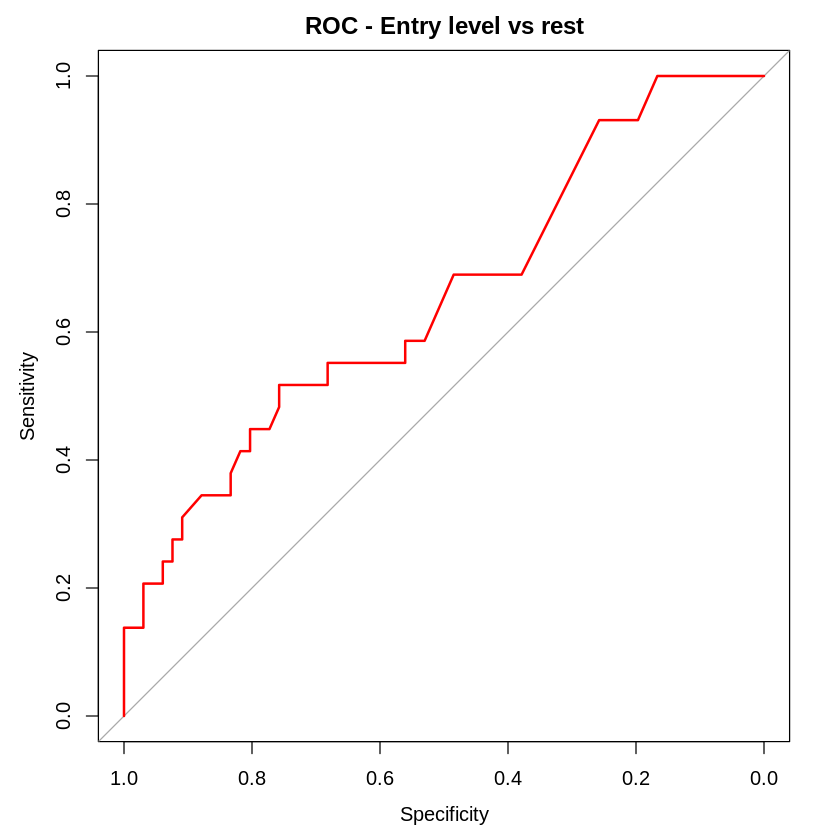

[1] "AUC Mid-Senior: 0.708670260557053"


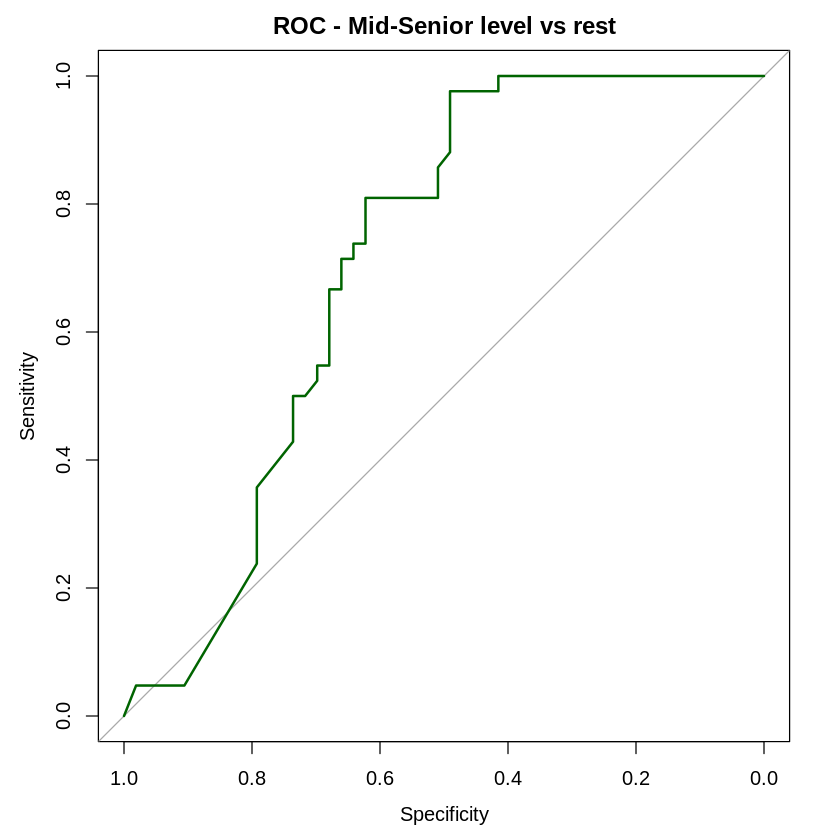

In [ ]:
# Entry level vs rest
train$binary_entry <- ifelse(train$Seniority == "Entry level", 1, 0)
test$binary_entry <- ifelse(test$Seniority == "Entry level", 1, 0)

model_entry <- randomForest(as.factor(binary_entry) ~ .,
                            data = train %>% select(-Seniority),
                            ntree = 500)

prob_entry <- predict(model_entry, newdata = test %>% select(-Seniority, -binary_entry), type = "prob")[,2]

roc_entry <- roc(test$binary_entry, prob_entry)
plot(roc_entry, col = "red", main = "ROC - Entry level vs rest")
print(paste("AUC Entry:", auc(roc_entry)))


# Mid-Senior level vs rest
train$binary_mid <- ifelse(train$Seniority == "Mid-Senior level", 1, 0)
test$binary_mid <- ifelse(test$Seniority == "Mid-Senior level", 1, 0)

model_mid <- randomForest(as.factor(binary_mid) ~ .,
                          data = train %>% select(-Seniority, -binary_entry),
                          ntree = 500)

prob_mid <- predict(model_mid, newdata = test %>% select(-Seniority, -binary_mid, -binary_entry), type = "prob")[,2]

roc_mid <- roc(test$binary_mid, prob_mid)
plot(roc_mid, col = "darkgreen", main = "ROC - Mid-Senior level vs rest")
print(paste("AUC Mid-Senior:", auc(roc_mid)))